In [1]:
import sys
sys.path.insert(0, '/Users/nina/Documents/treemap/treemap/analysis')
from config_figures import *

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from sklearn.datasets import make_blobs

In [3]:
# get ordination and covariate data
df = pd.read_csv('../../data/ordinations_covariates_1981_2010_biome.csv').drop(['system:index', '.geo'], axis=1)
df

,Axis1,Axis2,Axis3,CHELSA_bio12_1981_2010_V2_1,CHELSA_bio15_1981_2010_V2_1,CHELSA_bio1_1981_2010_V2_1,CHELSA_bio4_1981_2010_V2_1,CHELSA_gsl_1981_2010_V2_1,CHELSA_npp_1981_2010_V2_1,MDS1,MDS2,MDS3,Resolve_Biome,SG_Coarse_fragments_005cm,SG_Silt_Content_005cm,SG_Soil_pH_H2O_005cm,area,x,y
0,0.557363,-0.123118,-0.249818,7672.095271,659.648467,2722.982869,9809.050090,130.177219,5956.222400,-0.339311,0.100031,0.015596,8.954618,16.685503,40.529650,68.891319,6.288068e+09,96.5,-51.5
1,0.562486,-0.125693,-0.249034,7483.020973,697.474762,2722.079077,9547.541997,127.954441,6050.296739,-0.318566,0.111261,0.004869,8.506272,18.182417,42.182344,68.483872,6.288068e+09,97.5,-51.5
2,0.584105,-0.136452,-0.262094,7695.795344,780.525607,2720.436741,9440.837854,123.580668,5842.078745,-0.331557,0.097648,0.016789,9.323887,19.467710,41.996184,69.308732,6.288068e+09,98.5,-51.5
3,0.596256,-0.143971,-0.289196,8160.232779,914.179100,2696.915910,9179.055924,96.490764,4715.420553,-0.369970,0.158677,-0.013746,9.309113,22.429686,42.094637,68.129688,6.288068e+09,99.5,-51.5
4,0.554588,-0.108023,-0.268095,5897.241241,1060.343138,2689.288525,10060.417127,106.976508,4175.186728,-0.564437,0.012271,-0.030896,9.819797,21.179009,38.744711,71.617746,6.288068e+09,100.5,-51.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,0.263910,0.008874,-0.319804,3620.331081,849.427928,2562.133483,12368.610661,1.067568,1037.104204,-0.378482,0.375732,-0.424728,11.000000,23.441461,37.014009,68.585201,1.552391e+09,-113.5,-95.5
19531,0.263910,0.008874,-0.319804,1784.820226,749.377556,2564.531692,13731.053108,37.862448,1067.435243,-0.393002,0.354893,-0.427902,11.000000,29.631586,35.108469,69.331893,1.552391e+09,-105.5,-95.5
19532,0.263910,0.008874,-0.319804,1658.770470,703.070696,2565.979097,15418.188257,59.248569,1085.409666,-0.374453,0.381605,-0.423027,11.000000,26.971516,35.174600,70.162665,1.552391e+09,-103.5,-95.5
19533,0.263910,0.008874,-0.319804,1650.206162,712.858674,2560.454655,16089.408171,61.398660,1017.978433,-0.373773,0.390479,-0.419074,11.000000,25.536506,34.422878,70.305304,1.552391e+09,-102.5,-95.5


# PCA environmental variables

In [4]:
# compute PCA on environmental covariates
df_covs = df[[
    'CHELSA_bio12_1981_2010_V2_1', 'CHELSA_bio15_1981_2010_V2_1', 'CHELSA_bio1_1981_2010_V2_1', 
    'CHELSA_bio4_1981_2010_V2_1', 'CHELSA_gsl_1981_2010_V2_1', 'CHELSA_npp_1981_2010_V2_1', 
    'SG_Coarse_fragments_005cm', 'SG_Silt_Content_005cm', 'SG_Soil_pH_H2O_005cm'
]]
df_st = StandardScaler().fit_transform(df_covs)
pcamodel = PCA(n_components=2)
pca = pd.DataFrame(pcamodel.fit_transform(df_st)).rename(columns = {0:'pc1', 1:'pc2'})
scaled_pca = pca * (1.0 / (pca.max(axis=0) - pca.min(axis=0)))
scaled_pca

,pc1,pc2
0,-0.164394,-0.011980
1,-0.168747,-0.011713
2,-0.174123,0.009691
3,-0.201146,0.028948
4,-0.221528,0.086476
...,...,...
19530,-0.361684,0.028683
19531,-0.374036,0.021606
19532,-0.377825,0.002126
19533,-0.382103,0.000813


In [5]:
# compute variance explained by PCs
pca_variance_explained = pd.Series(pcamodel.explained_variance_ratio_, index=['pc1','pc2'])
pca_variance_explained

pc1    0.438662
pc2    0.265299
dtype: float64

In [6]:
# compute loadings of environmental covariates in PC space
pca_loadings = pd.DataFrame(pcamodel.components_.T, index = df_covs.columns, columns=['pc1','pc2'])
pca_loadings['var_name'] = ['Annual P', 'P season', 'MAT', 'T season', 'GSL', 'NPP', 'CF', 'Silt', 'pH']
pca_loadings

,pc1,pc2,var_name
CHELSA_bio12_1981_2010_V2_1,0.396485,-0.255254,Annual P
CHELSA_bio15_1981_2010_V2_1,-0.015762,0.472781,P season
CHELSA_bio1_1981_2010_V2_1,0.389413,0.360790,MAT
CHELSA_bio4_1981_2010_V2_1,-0.437969,-0.244097,T season
CHELSA_gsl_1981_2010_V2_1,0.431547,-0.219677,GSL
CHELSA_npp_1981_2010_V2_1,0.481241,-0.116788,NPP
SG_Coarse_fragments_005cm,-0.094442,0.053298,CF
SG_Silt_Content_005cm,-0.215826,-0.453108,Silt
SG_Soil_pH_H2O_005cm,-0.160516,0.501523,pH


In [7]:
# merge ordinations with PCA dataframe
df2 = scaled_pca.join(df[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3','x','y','area','Resolve_Biome']])
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,area,Resolve_Biome
0,-0.164394,-0.011980,-0.339311,0.100031,0.015596,0.557363,-0.123118,-0.249818,96.5,-51.5,6.288068e+09,8.954618
1,-0.168747,-0.011713,-0.318566,0.111261,0.004869,0.562486,-0.125693,-0.249034,97.5,-51.5,6.288068e+09,8.506272
2,-0.174123,0.009691,-0.331557,0.097648,0.016789,0.584105,-0.136452,-0.262094,98.5,-51.5,6.288068e+09,9.323887
3,-0.201146,0.028948,-0.369970,0.158677,-0.013746,0.596256,-0.143971,-0.289196,99.5,-51.5,6.288068e+09,9.309113
4,-0.221528,0.086476,-0.564437,0.012271,-0.030896,0.554588,-0.108023,-0.268095,100.5,-51.5,6.288068e+09,9.819797
...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028683,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,1.552391e+09,11.000000
19531,-0.374036,0.021606,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,1.552391e+09,11.000000
19532,-0.377825,0.002126,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,1.552391e+09,11.000000
19533,-0.382103,0.000813,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,1.552391e+09,11.000000


# Map 10%-90% quantiles to 0-1 for RGB color mapping

In [8]:
# scale ordinations (10-90% quantiles mapped to 0-1) for colors
def scale_to_0_1(vec):
    q10 = vec.quantile(0.1)
    q90 = vec.quantile(0.9)
    return vec.apply(lambda x: min(max((x-q10)/(q90-q10), 0), 1))

df2[['MDS1_red','MDS2_green','MDS3_blue']] = df2[['MDS1','MDS2','MDS3']].apply(scale_to_0_1)
nmds_colors = np.array(df2[['MDS1_red','MDS2_green','MDS3_blue']])
df2[['Axis1_green','Axis2_red','Axis3_blue']] = df2[['Axis1','Axis2','Axis3']].apply(scale_to_0_1)
evopca_colors = np.array(df2[['Axis2_red','Axis1_green', 'Axis3_blue']])
df2

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,area,Resolve_Biome,MDS1_red,MDS2_green,MDS3_blue,Axis1_green,Axis2_red,Axis3_blue
0,-0.164394,-0.011980,-0.339311,0.100031,0.015596,0.557363,-0.123118,-0.249818,96.5,-51.5,6.288068e+09,8.954618,0.128311,0.679607,0.505052,0.976318,0.029768,0.205376
1,-0.168747,-0.011713,-0.318566,0.111261,0.004869,0.562486,-0.125693,-0.249034,97.5,-51.5,6.288068e+09,8.506272,0.148945,0.698977,0.485904,0.984467,0.022550,0.207402
2,-0.174123,0.009691,-0.331557,0.097648,0.016789,0.584105,-0.136452,-0.262094,98.5,-51.5,6.288068e+09,9.323887,0.136024,0.675498,0.507181,1.000000,0.000000,0.173651
3,-0.201146,0.028948,-0.369970,0.158677,-0.013746,0.596256,-0.143971,-0.289196,99.5,-51.5,6.288068e+09,9.309113,0.097817,0.780760,0.452674,1.000000,0.000000,0.103608
4,-0.221528,0.086476,-0.564437,0.012271,-0.030896,0.554588,-0.108023,-0.268095,100.5,-51.5,6.288068e+09,9.819797,0.000000,0.528239,0.422061,0.971905,0.072080,0.158140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028683,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,1.552391e+09,11.000000,0.089351,1.000000,0.000000,0.509548,0.399737,0.024503
19531,-0.374036,0.021606,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,1.552391e+09,11.000000,0.074909,1.000000,0.000000,0.509548,0.399737,0.024503
19532,-0.377825,0.002126,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,1.552391e+09,11.000000,0.093358,1.000000,0.000000,0.509548,0.399737,0.024503
19533,-0.382103,0.000813,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,1.552391e+09,11.000000,0.094035,1.000000,0.000000,0.509548,0.399737,0.024503


# Plot NMDS and evoPCA in envioronmental PC-space

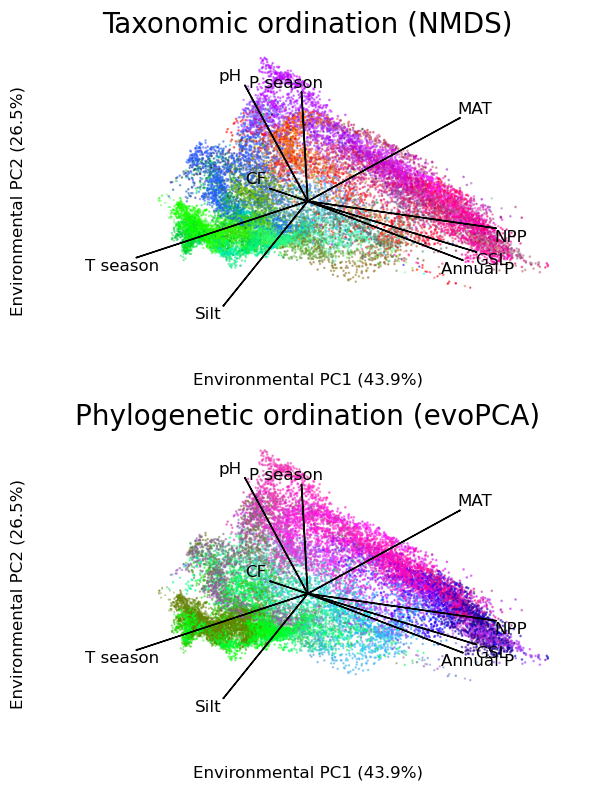

In [124]:
# figure with ordinations mapped into PC space 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))

ax1.scatter(x=df2['pc1'], y=df2['pc2'], c=nmds_colors, s=(df2['area']*1e-10), alpha=0.5)
ax1.set_title('Taxonomic ordination (NMDS)', fontsize=20)
ax2.scatter(x=df2['pc1'], y=df2['pc2'], c=evopca_colors, s=(df2['area']*1e-10), alpha=0.5)
ax2.set_title('Phylogenetic ordination (evoPCA)', fontsize=20)

for ax in [ax1, ax2]:
    ax.set_xlabel("Environmental PC1 (" + str(pca_variance_explained.pc1.round(3) * 100) + "%)", fontsize=12)
    ax.set_ylabel( "Environmental PC2 (" + str(pca_variance_explained.pc2.round(3) * 100) + "%)", fontsize=12)
    for r in pca_loadings.iterrows():
        ax.arrow(0, 0, r[1]['pc1'], r[1]['pc2'], color = 'k')
        text_x = r[1]['pc1'] + 0.04 if r[1]['pc1'] >= 0 else r[1]['pc1'] - 0.04
        text_y = r[1]['pc2'] + 0.04 if r[1]['pc2'] >= 0 else r[1]['pc2'] - 0.04
        ax.text(text_x, text_y, r[1]['var_name'], color = 'k', ha = 'center', va = 'center', fontsize=12)
    ax.set(xlim = (-0.7, 0.7), ylim = (-0.7, 0.7), xticklabels=[], xticks=[], yticklabels=[], yticks=[])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('../../figures/nmds_evopca_pca.png')

# Plot NMDS and evoPCA in 2d + distributions in 1d and 2d

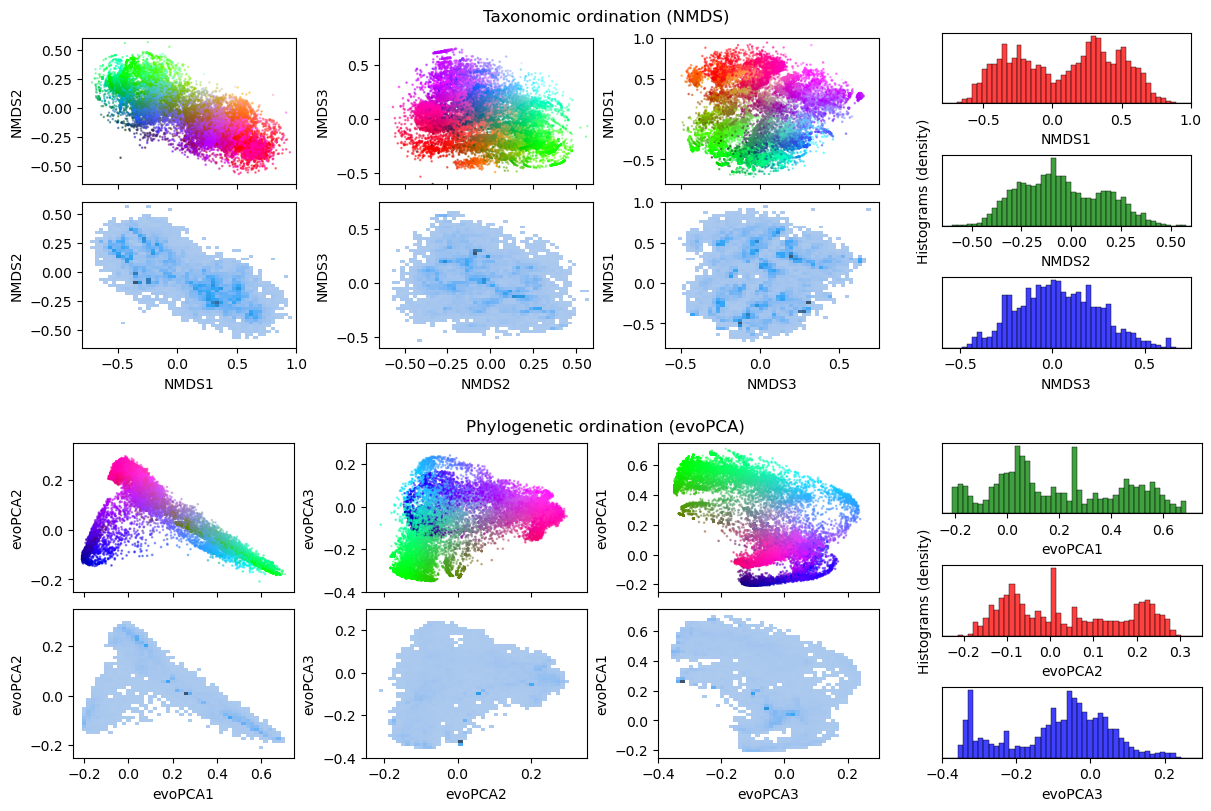

In [125]:
nbins = 50

fig = plt.figure(layout='constrained', figsize=(12,8))
subfigs = fig.subfigures(2, 1, hspace=0.05)

subfigs[0].suptitle('Taxonomic ordination (NMDS)')
subfigs_top = subfigs[0].subfigures(1, 2, wspace=0.05, width_ratios=[3,1])
axs_top_left = subfigs_top[0].subplots(2,3)

lim1 = (-0.8,1)
lim2 = (-0.65,0.6)
lim3 = (-0.6, 0.75)

ax1, ax2, ax3 = axs_top_left[0]
ax1.scatter(df2['MDS1'], df2['MDS2'], s=(df2['area']*1e-10), alpha=0.5, c=nmds_colors)
ax1.set(xlabel =None, ylabel='NMDS2', xlim=lim1, ylim=lim2, xticklabels=[])
ax2.scatter(df2['MDS2'], df2['MDS3'], s=(df2['area']*1e-10), alpha=0.5, c=nmds_colors)
ax2.set(xlabel =None, ylabel='NMDS3', xlim=lim2, ylim=lim3, xticklabels=[])
ax3.scatter(df2['MDS3'], df2['MDS1'], s=(df2['area']*1e-10), alpha=0.5, c=nmds_colors)
ax3.set(xlabel=None, ylabel='NMDS1', xlim=lim3, ylim=lim1, xticklabels=[])

ax1, ax2, ax3 = axs_top_left[1]
sns.histplot(df2, x='MDS1', y='MDS2', weights='area', bins=nbins, binrange=(lim1, lim2), ax=ax1)
ax1.set(xlabel='NMDS1', ylabel='NMDS2', xlim=lim1, ylim=lim2)
sns.histplot(df2, x='MDS2', y='MDS3', weights='area', bins=nbins, binrange=(lim2, lim3), ax=ax2)
ax2.set(xlabel='NMDS2', ylabel='NMDS3', xlim=lim2, ylim=lim3)
sns.histplot(df2, x='MDS3', y='MDS1', weights='area', bins=nbins, binrange=(lim3, lim1), ax=ax3)
ax3.set(xlabel='NMDS3', ylabel='NMDS1', xlim=lim3, ylim=lim1)

ax1, ax2, ax3 = subfigs_top[1].subplots(3,1)
sns.histplot(df2, x='MDS1', weights='area', stat='density', bins=nbins, binrange=lim1, color='red', ax=ax1)
ax1.set(xlabel = 'NMDS1', ylabel=None, yticklabels=[], yticks=[], xlim=lim1)
sns.histplot(df2, x='MDS2', weights='area', stat='density', bins=nbins, binrange=lim2, color='green', ax=ax2)
ax2.set(xlabel ='NMDS2', ylabel='Histograms (density)', yticklabels=[], yticks=[], xlim=lim2)
sns.histplot(df2, x='MDS3', weights='area', stat='density', bins=nbins, binrange=lim3, color='blue', ax=ax3)
ax3.set(xlabel ='NMDS3', ylabel=None, yticklabels=[], yticks=[], xlim=lim3)

subfigs[1].suptitle('Phylogenetic ordination (evoPCA)')
subfigs_bottom = subfigs[1].subfigures(1, 2, wspace=0.05, width_ratios=[3,1])
axs_bottom_left = subfigs_bottom[0].subplots(2,3)
lim1 = (-0.25,0.75)
lim2 = (-0.25,0.35)
lim3 = (-0.4, 0.3)

ax1, ax2, ax3 = axs_bottom_left[0]
ax1.scatter(df2['Axis1'], df2['Axis2'], s=(df2['area']*1e-10), alpha=0.5, c=evopca_colors)
ax1.set(xlabel =None, ylabel='evoPCA2', xticklabels=[], xlim=lim1, ylim=lim2)
ax2.scatter(df2['Axis2'], df2['Axis3'], s=(df2['area']*1e-10), alpha=0.5, c=evopca_colors)
ax2.set(xlabel =None, ylabel='evoPCA3', xticklabels=[], xlim=lim2, ylim=lim3)
ax3.scatter(df2['Axis3'], df2['Axis1'], s=(df2['area']*1e-10), alpha=0.5, c=evopca_colors)
ax3.set(xlabel=None, ylabel='evoPCA1', xticklabels=[], xlim=lim3, ylim=lim1)

ax1,ax2, ax3 = axs_bottom_left[1]
sns.histplot(df2, x='Axis1', y='Axis2', weights='area', bins=nbins, binrange=(lim1,lim2), ax=ax1)
ax1.set(xlabel='evoPCA1', ylabel='evoPCA2', xlim=lim1, ylim=lim2)
sns.histplot(df2, x='Axis2', y='Axis3', weights='area', bins=nbins, binrange=(lim2,lim3), ax=ax2)
ax2.set(xlabel='evoPCA2', ylabel='evoPCA3', xlim=lim2, ylim=lim3)
sns.histplot(df2, x='Axis3', y='Axis1', weights='area', bins=nbins, binrange=(lim3,lim1), ax=ax3)
ax3.set(xlabel='evoPCA3', ylabel='evoPCA1', xlim=lim3, ylim=lim1)

ax1, ax2, ax3 = subfigs_bottom[1].subplots(3, 1)
sns.histplot(df2, x='Axis1', weights='area', stat='density', bins=nbins, binrange=lim1, color='green', ax=ax1)
ax1.set(xlabel = 'evoPCA1', ylabel=None, yticklabels=[], yticks=[], xlim=lim1)
sns.histplot(df2, x='Axis2', weights='area', stat='density', bins=nbins, binrange=lim2, color='red', ax=ax2)
ax2.set(xlabel ='evoPCA2', ylabel='Histograms (density)', yticklabels=[], yticks=[], xlim=lim2)
sns.histplot(df2, x='Axis3', weights='area', stat='density', bins=nbins, binrange=lim3, color='blue', ax=ax3)
ax3.set(xlabel ='evoPCA3', ylabel=None, yticklabels=[], yticks=[], xlim=lim3)

#plt.show()
plt.savefig('../../figures/nmds_evopca_supp.png')

# Clustering analysis

In [126]:
# remove outliers from ordinations
df_ordinations = df2[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3']]
q1 = df_ordinations.quantile(0.25)
q3 = df_ordinations.quantile(0.75)
iqr = q3 - q1
df_nooutliers = df2[df_ordinations.apply(lambda x: (x >= q1[x.name] - 1.5*iqr[x.name]) & (x <= q3[x.name] + 1.5*iqr[x.name])).all(axis=1)]
df_nooutliers

,pc1,pc2,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,x,y,area,Resolve_Biome,MDS1_red,MDS2_green,MDS3_blue,Axis1_green,Axis2_red,Axis3_blue
0,-0.164394,-0.011980,-0.339311,0.100031,0.015596,0.557363,-0.123118,-0.249818,96.5,-51.5,6.288068e+09,8.954618,0.128311,0.679607,0.505052,0.976318,0.029768,0.205376
1,-0.168747,-0.011713,-0.318566,0.111261,0.004869,0.562486,-0.125693,-0.249034,97.5,-51.5,6.288068e+09,8.506272,0.148945,0.698977,0.485904,0.984467,0.022550,0.207402
2,-0.174123,0.009691,-0.331557,0.097648,0.016789,0.584105,-0.136452,-0.262094,98.5,-51.5,6.288068e+09,9.323887,0.136024,0.675498,0.507181,1.000000,0.000000,0.173651
3,-0.201146,0.028948,-0.369970,0.158677,-0.013746,0.596256,-0.143971,-0.289196,99.5,-51.5,6.288068e+09,9.309113,0.097817,0.780760,0.452674,1.000000,0.000000,0.103608
4,-0.221528,0.086476,-0.564437,0.012271,-0.030896,0.554588,-0.108023,-0.268095,100.5,-51.5,6.288068e+09,9.819797,0.000000,0.528239,0.422061,0.971905,0.072080,0.158140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19530,-0.361684,0.028683,-0.378482,0.375732,-0.424728,0.263910,0.008874,-0.319804,-113.5,-95.5,1.552391e+09,11.000000,0.089351,1.000000,0.000000,0.509548,0.399737,0.024503
19531,-0.374036,0.021606,-0.393002,0.354893,-0.427902,0.263910,0.008874,-0.319804,-105.5,-95.5,1.552391e+09,11.000000,0.074909,1.000000,0.000000,0.509548,0.399737,0.024503
19532,-0.377825,0.002126,-0.374453,0.381605,-0.423027,0.263910,0.008874,-0.319804,-103.5,-95.5,1.552391e+09,11.000000,0.093358,1.000000,0.000000,0.509548,0.399737,0.024503
19533,-0.382103,0.000813,-0.373773,0.390479,-0.419074,0.263910,0.008874,-0.319804,-102.5,-95.5,1.552391e+09,11.000000,0.094035,1.000000,0.000000,0.509548,0.399737,0.024503


In [127]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_nooutliers[['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3']]), columns = ['MDS1','MDS2','MDS3','Axis1','Axis2','Axis3'])
df_scaled = pd.concat([df_scaled, df_nooutliers[['x','y','area','MDS1_red','MDS2_green','MDS3_blue','Axis1_green','Axis2_red','Axis3_blue']].reset_index()], axis=1)
df_scaled

,MDS1,MDS2,MDS3,Axis1,Axis2,Axis3,index,x,y,area,MDS1_red,MDS2_green,MDS3_blue,Axis1_green,Axis2_red,Axis3_blue
0,-0.886902,0.445985,0.064818,1.259302,-1.076870,-0.846345,0,96.5,-51.5,6.288068e+09,0.128311,0.679607,0.505052,0.976318,0.029768,0.205376
1,-0.832535,0.497639,0.015633,1.280457,-1.096656,-0.841084,1,97.5,-51.5,6.288068e+09,0.148945,0.698977,0.485904,0.984467,0.022550,0.207402
2,-0.866580,0.435028,0.070287,1.369722,-1.179328,-0.928684,2,98.5,-51.5,6.288068e+09,0.136024,0.675498,0.507181,1.000000,0.000000,0.173651
3,-0.967249,0.715724,-0.069723,1.419891,-1.237110,-1.110474,3,99.5,-51.5,6.288068e+09,0.097817,0.780760,0.452674,1.000000,0.000000,0.103608
4,-1.476891,0.042339,-0.148355,1.247846,-0.960873,-0.968940,4,100.5,-51.5,6.288068e+09,0.000000,0.528239,0.422061,0.971905,0.072080,0.158140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19442,-0.989557,1.714055,-1.954152,0.047630,-0.062613,-1.315784,19530,-113.5,-95.5,1.552391e+09,0.089351,1.000000,0.000000,0.509548,0.399737,0.024503
19443,-1.027609,1.618207,-1.968709,0.047630,-0.062613,-1.315784,19531,-105.5,-95.5,1.552391e+09,0.074909,1.000000,0.000000,0.509548,0.399737,0.024503
19444,-0.978998,1.741069,-1.946356,0.047630,-0.062613,-1.315784,19532,-103.5,-95.5,1.552391e+09,0.093358,1.000000,0.000000,0.509548,0.399737,0.024503
19445,-0.977215,1.781882,-1.928228,0.047630,-0.062613,-1.315784,19533,-102.5,-95.5,1.552391e+09,0.094035,1.000000,0.000000,0.509548,0.399737,0.024503


In [128]:
nmds = df_scaled[['MDS1','MDS2','MDS3']]
nmds_scores = []
for k in range(2,50):
    labels = KMeans(n_clusters=k).fit_predict(nmds)
    score = silhouette_score(nmds, labels)
    nmds_scores.append(score)

In [129]:
evopca = df_scaled[['Axis1','Axis2','Axis3']]
evocpca_scores = []
for k in range(2,50):
    labels = KMeans(n_clusters=k).fit_predict(evopca)
    score = silhouette_score(evopca, labels)
    evocpca_scores.append(score)

# Cluster analysis plot

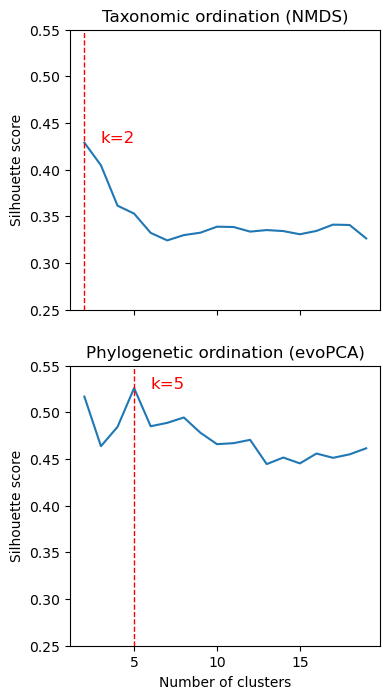

In [130]:
max_k = 20
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(4,8))

sns.lineplot(x=range(2,max_k), y=nmds_scores[:max_k-2], ax=ax1)
ax1.set(ylabel='Silhouette score', ylim=(0.25,0.55), title='Taxonomic ordination (NMDS)')
ax1.axvline(np.argmax(nmds_scores)+2, color='red', linestyle="--", linewidth=1)
ax1.text(np.argmax(nmds_scores)+3, max(nmds_scores), "k=" + str(np.argmax(nmds_scores)+2), fontsize=12, color='red')

sns.lineplot(x=range(2,max_k), y=evocpca_scores[:max_k-2], ax=ax2)
ax2.set(xlabel='Number of clusters', ylabel='Silhouette score', title='Phylogenetic ordination (evoPCA)')
ax2.axvline(np.argmax(evocpca_scores)+2, color='red', linestyle="--", linewidth=1)
ax2.text(np.argmax(evocpca_scores)+3, max(evocpca_scores), "k=" + str(np.argmax(evocpca_scores)+2), fontsize=12, color='red')

#plt.show()
plt.savefig('../../figures/nmds_evopca_supp_cluster.png')

# Save csv of best clustering solution

In [131]:
df_scaled['nmds_cluster'] = KMeans(n_clusters=2).fit_predict(nmds)
df_scaled['evopca_cluster'] = KMeans(n_clusters=5).fit_predict(evopca)
df_scaled[['x','y','nmds_cluster','evopca_cluster']].to_csv('../../data/ordinations_cluster.csv', index=False)